In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

raw_data = pd.read_csv('final_data.csv')

In [2]:
data = raw_data.copy()

In [3]:
# convert dates back to datetime

# Times
time_cols = ['posted_time', 'disbursed_time']
for col in time_cols:
    data[col] = pd.to_datetime(data[col])


# female ratio for correlation
data["total_num"] = data["num_female_borrowers"] + data["num_male_borrowers"]
data["ratio_female"] = data["num_female_borrowers"].astype('float') / data["total_num"].astype('float')

In [4]:
(data['funding_velocity'] == float('inf')).sum()

1090

Not really sure why there are a few infinite values for `funding_velocity`... I guess this means they were funded instantly/before the loan was posted. I'm going to remove these for now to make visualization possible.

In [5]:
# remove inf for plotting
plottable_data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=["funding_velocity"], how="all")

In [6]:
data = plottable_data.copy()

## Correlations

In [7]:
# correlations

numeric_data = data.select_dtypes(include=['float64'])

corr = numeric_data.corr()
corr["funding_velocity"]

funded_amount                        0.198656
loan_amount                          0.187296
partner_id                          -0.022325
term_in_months                      -0.025746
partner_id.1                        -0.022325
number                               0.029489
amount                               0.074514
rural_pct                           -0.012165
mpi_national                        -0.027869
mpi_regional                        -0.025884
headcount_ratio_regional            -0.028228
intensity_of_deprivation_regional   -0.031656
mpi_urban                           -0.023638
headcount_ratio_urban               -0.025202
intensity_of_deprivation_urban      -0.037798
mpi_rural                           -0.022811
headcount_ratio_rural               -0.021330
intensity_of_deprivation_rural      -0.040817
hours_till_funded                   -0.075118
expected_funding_velocity            0.187296
expected_hours_till_funded           0.095387
percent_funded                    

No obvious correlations, at this point, apart from the `loan_amount` and `expected_funding_velocity` relationships we should expect.

In [8]:
corr["mpi_regional"]

funded_amount                        0.036962
loan_amount                          0.041569
partner_id                           0.267224
term_in_months                      -0.006072
partner_id.1                         0.267224
number                               0.163880
amount                               0.029473
rural_pct                            0.203573
mpi_national                         0.765262
mpi_regional                         1.000000
headcount_ratio_regional             0.987892
intensity_of_deprivation_regional    0.635439
mpi_urban                            0.700235
headcount_ratio_urban                0.710108
intensity_of_deprivation_urban       0.566479
mpi_rural                            0.749011
headcount_ratio_rural                0.753715
intensity_of_deprivation_rural       0.482157
hours_till_funded                    0.037193
expected_funding_velocity            0.041569
expected_hours_till_funded          -0.044535
percent_funded                    

Nothing super surprising here. It's worth noting that `mpi_regional` and `headcount_ratio_regional` are nearly perfectly correlated.

## Temporal features

In [9]:
loan_timing = pd.DataFrame(data["id"])

In [10]:
loan_timing['hour_posted'] = data.posted_time.map(lambda row: row.hour)
loan_timing['weekday_posted'] = data.posted_time.map(lambda row: row.weekday())
loan_timing['month_posted'] = data.posted_time.map(lambda row: row.month)

In [11]:
loans_with_timing = pd.merge(loan_timing, data, on="id")

### Time of day/week/year posted

In [12]:
data_no_outliers = loans_with_timing.sort_values('funding_velocity', ascending=True)

In [13]:
data_no_outliers = data_no_outliers.head(round(len(data_no_outliers) * .98))

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


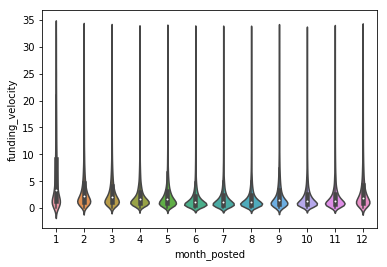

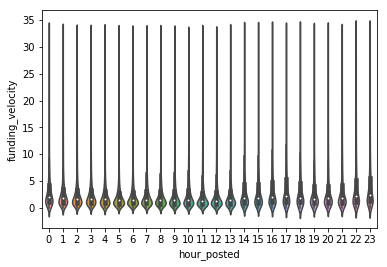

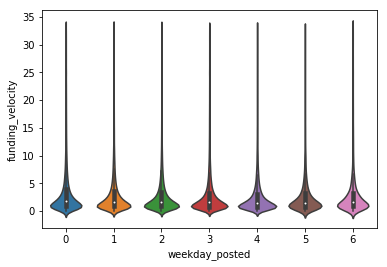

In [14]:
sns.violinplot(x="month_posted", y="funding_velocity", data=data_no_outliers)
plt.show()

sns.violinplot(x="hour_posted", y="funding_velocity", data=data_no_outliers)
plt.show()

sns.violinplot(x="weekday_posted", y="funding_velocity", data=data_no_outliers)
plt.show()

In [15]:
loans_with_timing.groupby('month_posted').mean()['funding_velocity']

month_posted
1     14.763514
2      5.944007
3      7.055509
4      3.033036
5      3.350015
6      2.641972
7      2.611447
8      2.789569
9      5.363128
10     2.685934
11     3.274549
12     7.698752
Name: funding_velocity, dtype: float64

It looks like loans posted in the winter (particularly around the holidays) generally have a higher funding velocity.

### Velocity over time

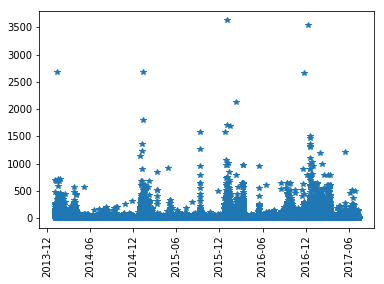

In [16]:
df = data.sort_values('posted_time', ascending=True)
plt.plot(df['posted_time'], df['funding_velocity'], '*')
plt.xticks(rotation='vertical')

plt.show()

Here again, we can see the trend for a spike in funding velocity around Dec/Jan every year.

## Loan Purpose

We have three features related to loan purpose: `sector`, `activity`, and `loan_theme_type`.

In [17]:
%matplotlib inline

In [18]:
colors = ['#455e8e', '#7489ad']

def plot_categorical(category, dataset=data, numeric_feature='funding_velocity'):
    plt.figure(figsize=(15,8))
    count = round(dataset.groupby([category])[numeric_feature].mean().sort_values(ascending=False), 2)
    sns.barplot(count.values, count.index, )
    for i, v in enumerate(count.values):
        plt.text(0.8,i,v,color='k',fontsize=12)
    plt.xlabel(numeric_feature, fontsize=20)
    plt.ylabel(category, fontsize=20)
    plt.show()
    
def plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='sector', 
                     d=data, 
                     scale_first=True):
    # average by category, sort
    count_a = d.groupby([category])[feature_a].mean().sort_values(ascending=False).to_frame()
    count_a[category] = count_a.index.values
    # average by category
    count_b = d.groupby([category])[feature_b].mean().to_frame()
    count_b[category] = count_b.index.values
    # merge on sorted category
    counts = count_a.merge(count_b, how='left', on=category)
    # scale if necessary, plot
    if scale_first:
        counts[feature_a] = counts[feature_a]*100 # scale
    counts.plot(kind='bar', stacked=True, color=colors)

### Sector

In [19]:
len(data['sector'].unique())

15

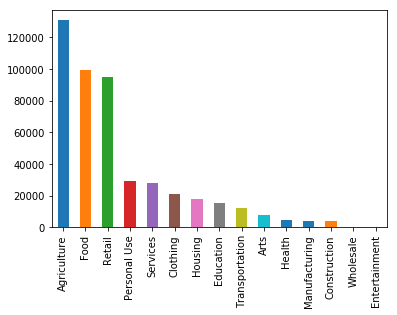

In [20]:
data.sector.value_counts().plot.bar()

This is by far our least granular category, with 15 values.

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


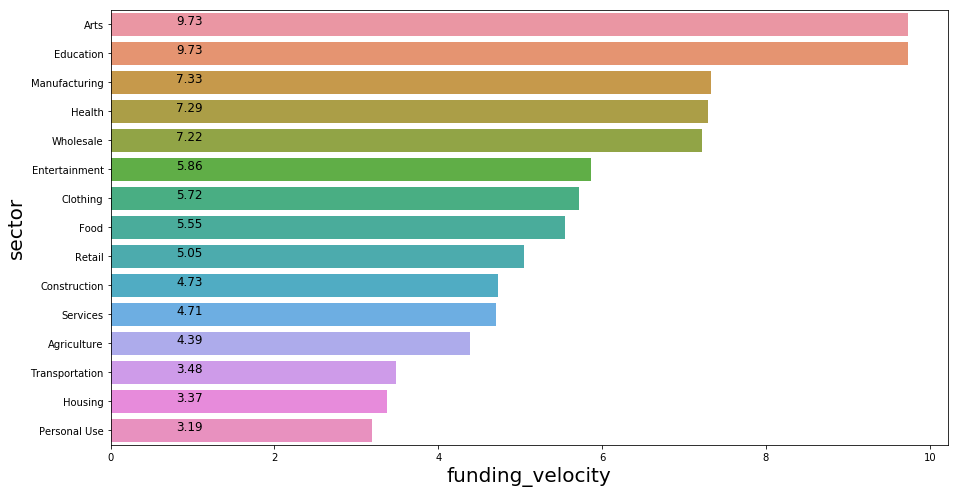

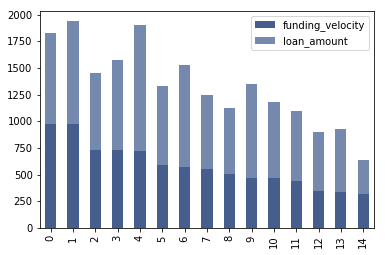

In [21]:
plot_categorical('sector', data)

plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='sector', 
                     d=data, 
                     scale_first=True)

Difference in `funding_velocity` for each category does not vary too closely with `loan_amount`, interestingly.

### Activity

In [22]:
len(data['activity'].unique())

162

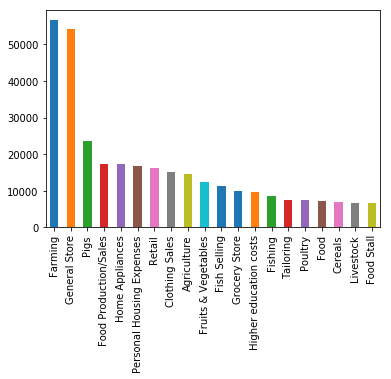

In [23]:
data.activity.value_counts().head(20).plot.bar()

Activity is significantly finer grained, with 162 values. Aside from being more fine-grained, the categories are very similar.

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


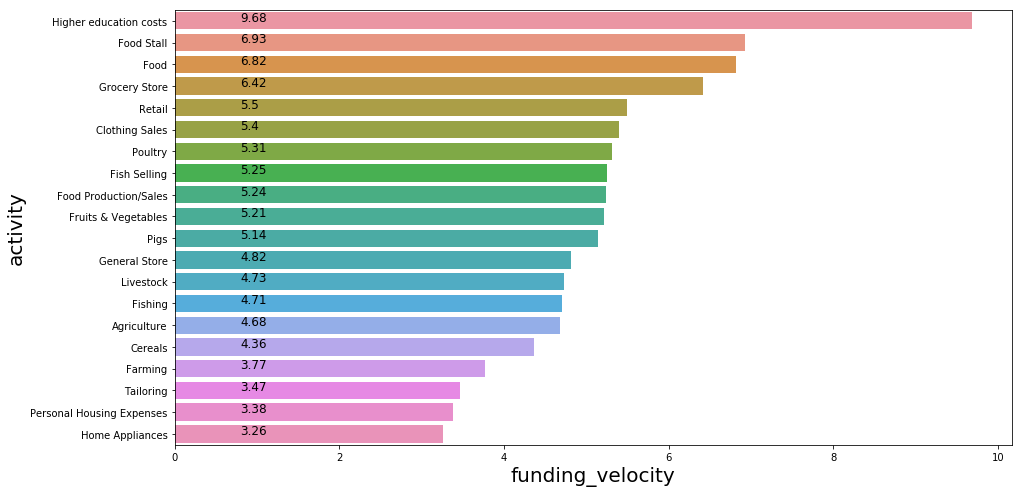

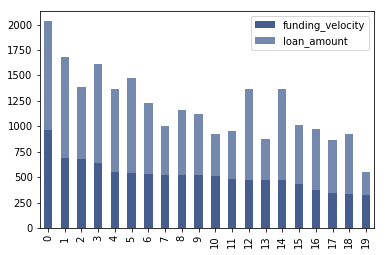

In [24]:
# plot velocity for most common activities
top_activities = data.activity.value_counts().head(20).index.values
activities = data.loc[data['activity'].isin(top_activities)]

plot_categorical('activity', activities)

plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='activity', 
                     d=activities, 
                     scale_first=True)

### Loan theme type

In [25]:
len(data['loan_theme_type'].unique())

110

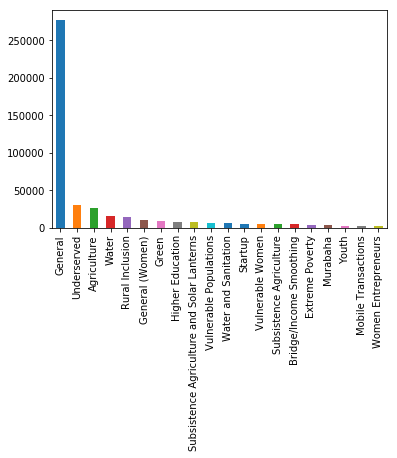

In [26]:
data.loan_theme_type.value_counts().head(20).plot.bar()

`loan_theme_type` is slightly less fine-grained than `activity`, with 110 values. The categories here are not the same, however. Rather than just looking at the usage, `loan_theme_type` takes into account qualities of the borrower (women entrepeneurs, for example.)

In [27]:
print((data.loan_theme_type != 'General').sum() / data.shape[0])
print((data.loan_theme_type == 'Women Entrepreneurs').sum())

0.4109019003507816
1937


40% of our data falls into the `general` theme.

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


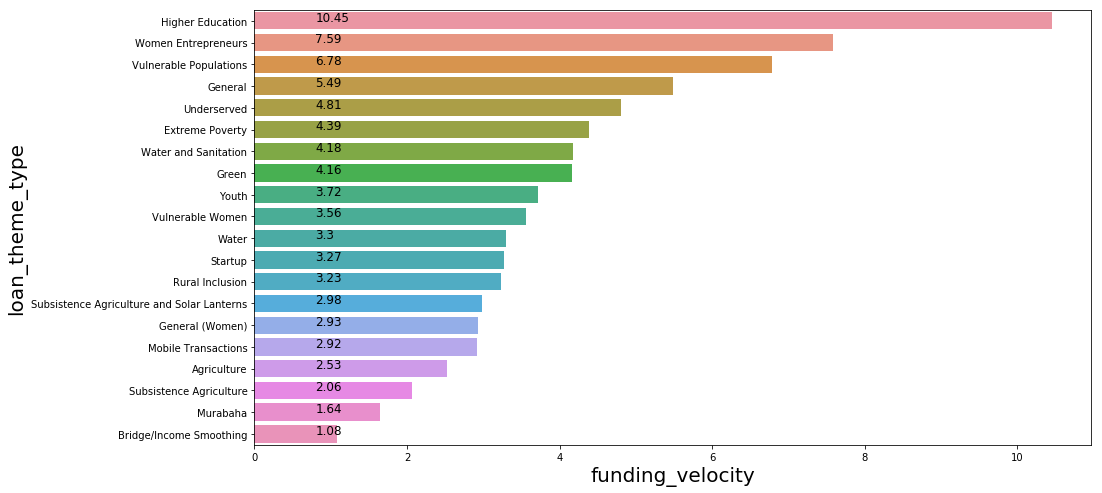

In [28]:
top_themes = data.loan_theme_type.value_counts().head(20).index.values
loans = data.loc[data['loan_theme_type'].isin(top_themes)]

plot_categorical('loan_theme_type', dataset=loans)

Despite the overwhelming `general` category, this feature is very interesting. We should look at it closer to see if we extract something from it in the feature transformation process.

## Country

In [29]:
print(len(data['country'].unique()))
data['country'].value_counts()

54


Philippines                             149517
Kenya                                    63349
Cambodia                                 32497
Pakistan                                 26487
Uganda                                   19101
Tajikistan                               19016
El Salvador                              15752
Peru                                     15295
Colombia                                 13541
Ecuador                                  10978
Nigeria                                   9971
Nicaragua                                 8635
Bolivia                                   8319
Guatemala                                 5041
Honduras                                  5025
Tanzania                                  5022
Indonesia                                 4899
Sierra Leone                              4240
Jordan                                    4123
Ghana                                     3846
Zimbabwe                                  3534
Mozambique   

#### Common countries

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


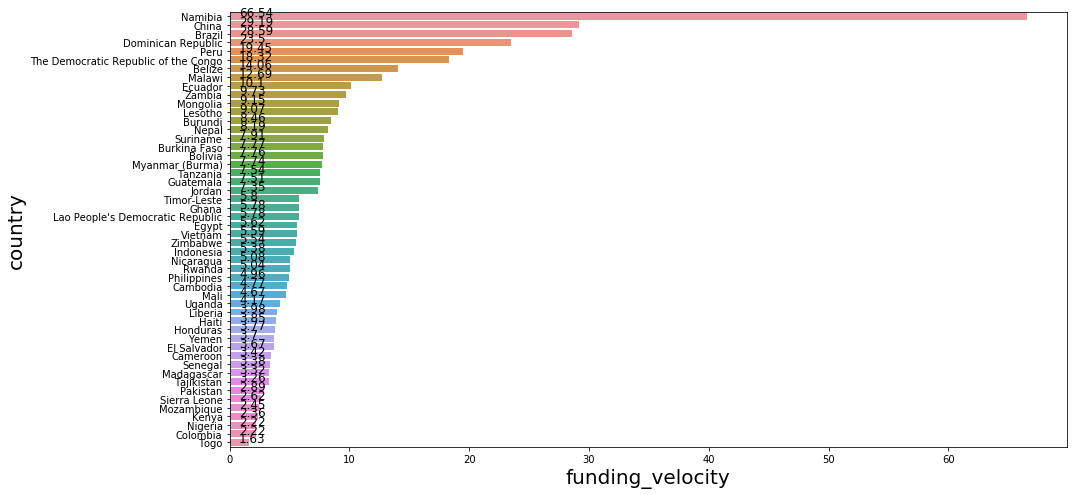

In [30]:
# plot velocity time for most common countries
top_countries = data.country.value_counts().head(50).index.values
countries = data.loc[data['country'].isin(top_countries)]

plt.figure(figsize=(15,8))
plot_categorical('country', countries)

There is significant variation in velocity between countries, so it definitely seems like a useful feature to include.

#### Least common countries

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


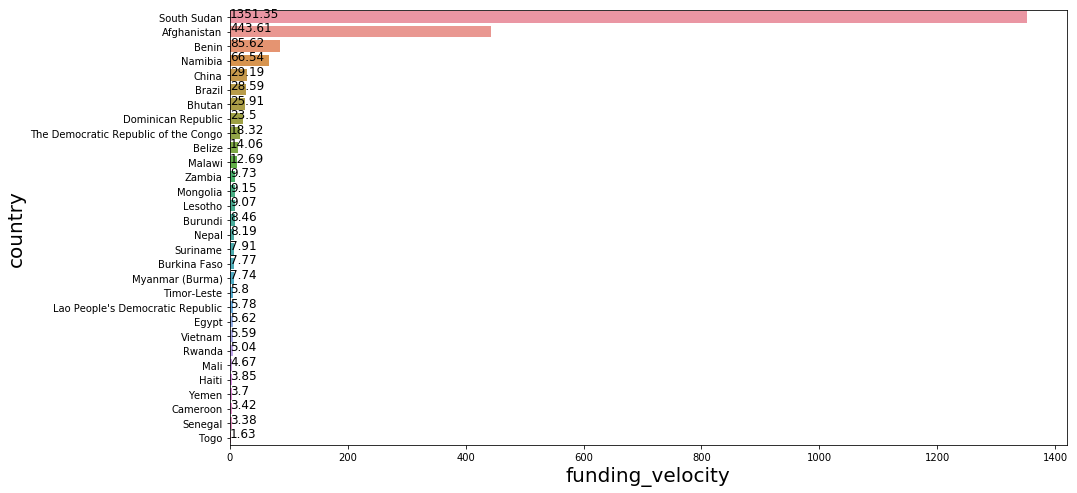

In [31]:
# plot velocity time for least common countries
top_countries = data.country.value_counts().tail(30).index.values
uncommon_countries = data.loc[data['country'].isin(top_countries)]

plt.figure(figsize=(15,8))
plot_categorical('country', uncommon_countries)

Variance not super meaningful with these countries–South Sudan has only one instance.

In [32]:
print(len(data[data['country'] == 'South Sudan']))

1


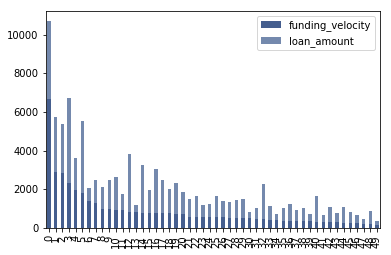

In [33]:
plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='country', 
                     d=countries, 
                     scale_first=True)

Here again, the funding velocity and loan amount are not closely related within each country.

## Loan Terms

### Repayment Interval

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


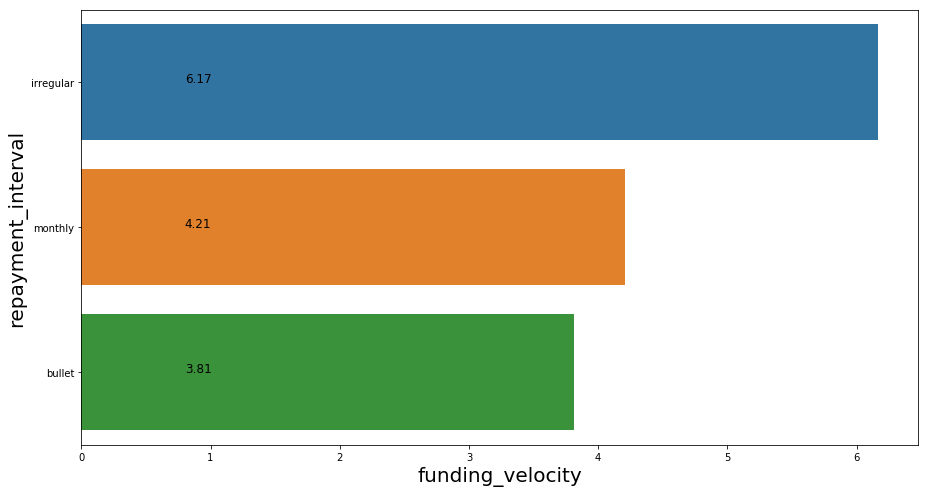

In [34]:
plot_categorical('repayment_interval', countries)

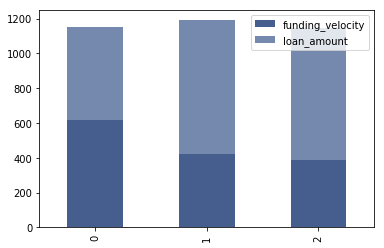

In [35]:
plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='repayment_interval', 
                     d=data, 
                     scale_first=True)

### Term in months

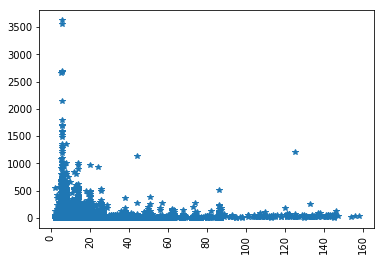

In [36]:
plt.plot(data['term_in_months'], data['funding_velocity'], '*')
plt.xticks(rotation='vertical')

plt.show()

### Lender Count

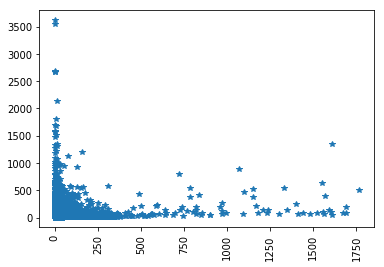

In [37]:
plt.plot(data['lender_count'], data['funding_velocity'], '*')
plt.xticks(rotation='vertical')

plt.show()

As I would expect, loans with few funders (larger donations) were funded exponentially faster. While this is an important factor, clearly, I wonder about including it in the feature set because we are trying to *predict* funding velocity ahead of time – `lender_count` is not a known factor until after the loan has been funded.

### Field Partner

In [38]:
print(data.field_partner_name.value_counts().head(20))
print("Total Unique Partners: " + str((data.field_partner_name.value_counts()).sum()))

Negros Women for Tomorrow Foundation (NWTF)    103663
CrediCampo                                      15424
Juhudi Kilimo                                   15391
iDE Cambodia                                    14447
BRAC Pakistan                                   13564
SMEP Microfinance Bank                          12987
Paglaum Multi-Purpose Cooperative (PMPC)        12909
Community Economic Ventures, Inc. (CEVI)        12311
HOFOKAM                                         10467
VisionFund Cambodia                             10437
Yehu Microfinance Trust                         10405
Interactuar                                     10331
VisionFund Kenya                                10325
Kashf Foundation                                10203
Babban Gona Farmers Organization                 9845
AsociaciÍ_n Arariwa                              9567
Humo                                             8292
IMON International                               8275
Gata Daku Multi-purpose Coop

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


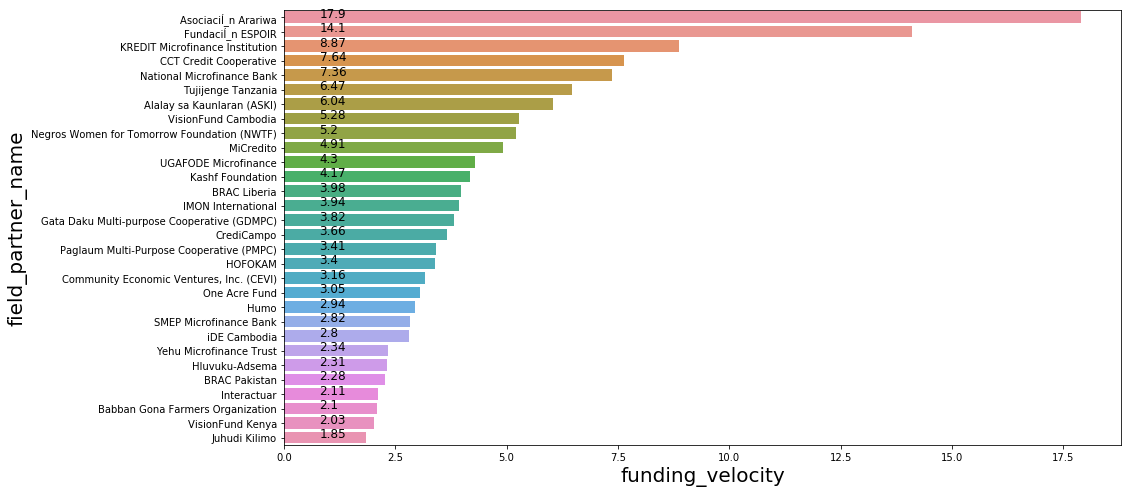

In [39]:
top_partners = data.field_partner_name.value_counts().head(30).index.values
partners = data.loc[data['field_partner_name'].isin(top_partners)]

plt.figure(figsize=(15,8))
plot_categorical('field_partner_name', partners)

I'm noticing that a lot of the field partners have places in the name. Lets see how closely related field partners are to countries.

In [40]:
for partner in top_partners:
    print(partner.upper())
    counts = data[data["field_partner_name"] == partner]['country'].value_counts()
    for i in range(len(counts)):
        print(counts.index[i])
        print(counts[i])
    print()

NEGROS WOMEN FOR TOMORROW FOUNDATION (NWTF)
Philippines
103663

CREDICAMPO
El Salvador
15424

JUHUDI KILIMO
Kenya
15391

IDE CAMBODIA
Cambodia
14447

BRAC PAKISTAN
Pakistan
13564

SMEP MICROFINANCE BANK
Kenya
12987

PAGLAUM MULTI-PURPOSE COOPERATIVE (PMPC)
Philippines
12909

COMMUNITY ECONOMIC VENTURES, INC. (CEVI)
Philippines
12311

HOFOKAM
Uganda
10467

VISIONFUND CAMBODIA
Cambodia
10437

YEHU MICROFINANCE TRUST
Kenya
10405

INTERACTUAR
Colombia
10331

VISIONFUND KENYA
Kenya
10325

KASHF FOUNDATION
Pakistan
10203

BABBAN GONA FARMERS ORGANIZATION
Nigeria
9845

ASOCIACIÍ_N ARARIWA
Peru
9567

HUMO
Tajikistan
8292

IMON INTERNATIONAL
Tajikistan
8275

GATA DAKU MULTI-PURPOSE COOPERATIVE (GDMPC)
Philippines
7410

ONE ACRE FUND
Kenya
7187

CCT CREDIT COOPERATIVE
Philippines
6917

FUNDACIÍ_N ESPOIR
Ecuador
5603

ALALAY SA KAUNLARAN (ASKI)
Philippines
5509

TUJIJENGE TANZANIA
Tanzania
4319

NATIONAL MICROFINANCE BANK
Jordan
4104

UGAFODE MICROFINANCE
Uganda
4056

KREDIT MICROFINANCE INSTITUT

It looks like these partners are closely tied to countries. Lets see how closely countries are tied to partners.

In [41]:
top_countries = data.country.value_counts().head(30).index.values

for country in top_countries:
    print(country.upper())
    counts = data[data["country"] == country]['field_partner_name'].value_counts()
    for i in range(len(counts)):
        print(counts.index[i])
        print(counts[i])
    print()

PHILIPPINES
Negros Women for Tomorrow Foundation (NWTF)
103663
Paglaum Multi-Purpose Cooperative (PMPC)
12909
Community Economic Ventures, Inc. (CEVI)
12311
Gata Daku Multi-purpose Cooperative (GDMPC)
7410
CCT Credit Cooperative
6917
Alalay sa Kaunlaran (ASKI)
5509
SEED Center Philippines
620
BagoSphere
177
N/A, direct to Kalsada
1

KENYA
Juhudi Kilimo
15391
SMEP Microfinance Bank
12987
Yehu Microfinance Trust
10405
VisionFund Kenya
10325
One Acre Fund
7187
Hand in Hand Eastern Africa
3248
Kenya ECLOF
2849
Digital Divide Data (DDD)
233
Sanergy
225
Asante Kenya Foundation
152
Junior Achievement Kenya
74
iSmart Kenya
74
Takamoto Biogas
72
Burn Manufacturing
44
Housing Finance Foundation
29
Moringa School
24
Strathmore University
17
Unreasonable Institute
2
PowerGen Renewable Energy
2
N/A, direct to SCODE
1
N/A, direct to Moko Furniture (Watervale Investments)
1
N/A, direct to EcoZoom
1
N/A, direct to LLK
1
N/A, direct to ICT4D
1
N/A, direct to Vava Coffee
1
N/A, direct to Pawame
1
Fledge

It seems like partners are a very local thing, tied closely to countries. Because of this, I doubt that kiva funders would have the background knowledge required to make partners a part of their decision. This could be looked at more,  but I'm going to put it aside for now.

Using countries (which partners are closely correlated with) is likely much more useful for our model.

## Currency

In [42]:
len(data['currency'].unique())

44

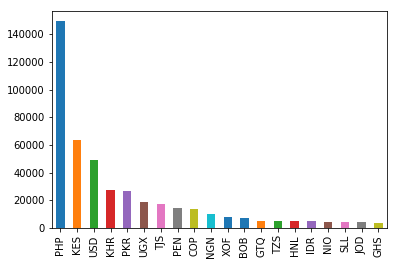

In [43]:
data.currency.value_counts().head(20).plot.bar()

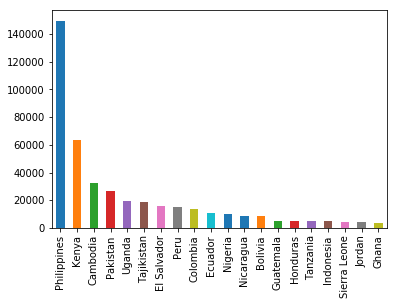

In [44]:
data.country.value_counts().head(20).plot.bar()

Looks like the main difference between country and currency is that USD is an aggregate of many countries.

In [45]:
usd = data[data["currency"] == "USD"]["country"].value_counts()
print("USD:")
print(usd)
print()

print("PHP:")
usd = data[data["currency"] == "PHP"]["country"].value_counts()
print(usd)

USD:
El Salvador                             15752
Ecuador                                 10978
Cambodia                                 4827
Nicaragua                                4094
Zimbabwe                                 3533
The Democratic Republic of the Congo     2963
Timor-Leste                              2386
Tajikistan                               1822
Bolivia                                  1347
Peru                                      742
Mongolia                                  233
Haiti                                     150
Ghana                                     112
Indonesia                                 103
Honduras                                   94
Kenya                                      46
Guatemala                                  35
Tanzania                                   24
Rwanda                                     14
Brazil                                     14
China                                       8
Uganda                       

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


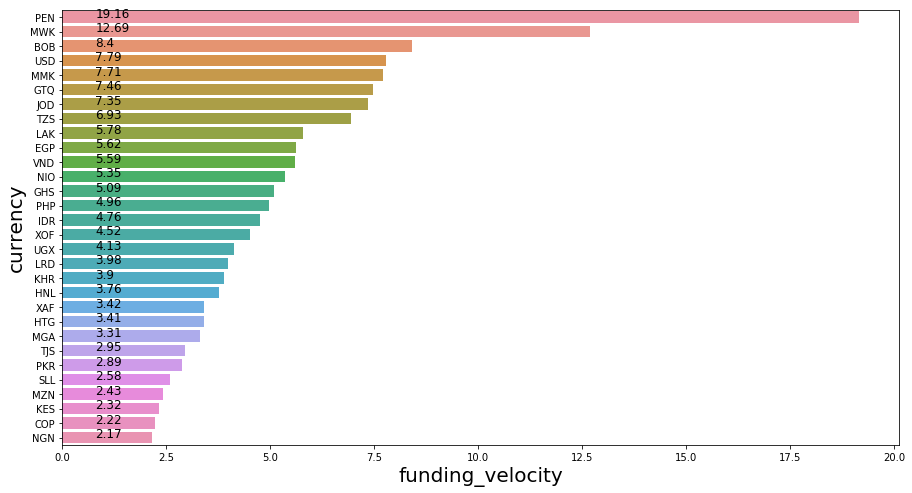

In [46]:
top = data.currency.value_counts().head(30).index.values
c = data.loc[data['currency'].isin(top)]

plot_categorical('currency', c)

Same general trends as the country feature.

## MPI dataset features

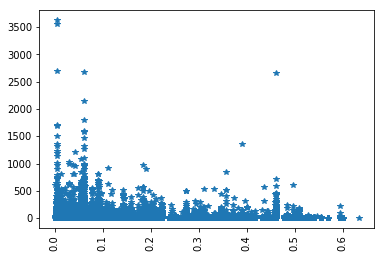

In [47]:
plt.plot(data['mpi_regional'], data['funding_velocity'], '*')
plt.xticks(rotation='vertical')

plt.show()

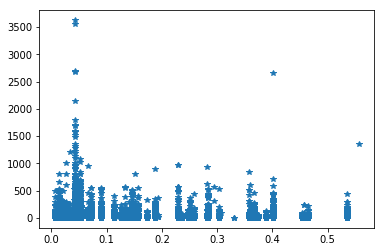

In [48]:
plt.plot(data['mpi_national'], data['funding_velocity'], '*')
plt.show()

Interestingly weak relationships here.

# Summary of Potential Features

#### Time of the year posted
There appears to be a spike in funding velocity around the holidays every year, and velocity also reaches a low point during the summer months. We can probably use this feature (`month_posted`) directly as a continuous value.

#### Loan Purpose
We have three loan purpose related variables:
- `sector`: least granular (15 values), related solely to use
- `activity`:  more granular (160 values), related solely to use
- `loan_theme_type`: more granular (110 values), considers both use and borrower

We should look at these features a little closer in the transformation process, to see how much information we lose in going from `activity` to `sector`.

#### Country
Definitely should use, upon some transformation. It probably wouldn't hurt to group together some of the countries with only few instances, if nothing else.

#### Repayment Interval
Interestingly, irregular loan terms have the highest velocity. With only three possible values, my instinct would be to dummify this as a categorical variable rather than to turn it into a continuous variable. Despite the fact that this increases our number of features by 1, I’m afraid turning this into a continuous variable could do weird things…

#### Term in months
Loans with extremely low terms have a significant bump in velocity. We noticed that “short term loans” is actually a filter on Kiva’s website. Definitely useful.

#### Lender Count - Not useful?
While this shows a similar trend to the previous feature (low lender counts -> high velocity), we're doubtful about wether we should use it in our model because it’s not information that you will have available when predicting a loan’s velocity before it’s funded.

#### Field Partner - Not useful
Highly localized, probably not useful.
